In [1]:
# main issues:
# fix stop loss/ max wdd
# partial fills
# multiple pairs at one time
# issues with multiple pairs with similar legs, memory management
# trailing profit take
#     1) take 
#     1) sell bad leg and use winning leg to run    

# innovations
# increase volume
# make new models whcih are scalping or momentum models

# kalmans filters
# copulas
# nonlinear distributions
# extreme value theory
# last three are similar
# pair trading with multiple exchanges

# limit orders
# max win drawdown
# advanced risk mitigation 
# if long and first priotirty to get rid off -> sell at market
# if short and first prioity to get rid off -> sell at market
# pair splitting

In [2]:
# imports and requirements
import json
import requests
import pandas as pd
import numpy as np
import ccxt
import time
import datetime as dt
import matplotlib.pyplot as plt

from binance.client import Client
from binance.enums import *

In [3]:
# init client
apiKey = 'Xo3vFSsM4XoYge93eqCA3gxmHQTN3rWqOs1LtUsHK9UQDKFcvRp1hMRmIiFIolsh'
apiSecret = ';)'

# python-binance init
client = Client(apiKey, apiSecret)
# ccxt init
exchange = ccxt.binance({
    'apiKey': 'Xo3vFSsM4XoYge93eqCA3gxmHQTN3rWqOs1LtUsHK9UQDKFcvRp1hMRmIiFIolsh',
    'secret': ';)',
    'enableRateLimit': True,  # as required by the Manual
    'options': { 'defaultType': 'future' }
})

In [4]:
# inputs
# leg1 = input("Input leg 1: ")
# leg2 = input("Input leg 2: ")
# timeframe = input("Input timeframe/ interval: ")
# emalen = input("Input Lookback/ EMA length: ")
# legval = float(input("Leg Value: "))

leg1 = 'BCHUSDT'
leg2 = 'LTCUSDT'
timeframe = '30m'
emalen = '20'
legval = float(input("Leg Value: "))

# convert legs
if leg1 == 'ONTUSDT':
    newLeg1 = 'ONT/USDT'
    # prec = 1 dp, 4 price
elif leg1 == 'ETHUSDT':
    newLeg1 = 'ETH/USDT'
    # prec = 3 dp, 2 price
elif leg1 == 'BCHUSDT':
    newLeg1 = 'BCH/USDT'
    # prec = 3 dp, 2 price
elif leg1 == 'TRXUSDT':
    newleg1 = 'TRX/USDT'
    # prec = 0 dp, 5 price
    
if leg2 == 'QTUMUSDT':
    newLeg2 = 'QTUM/USDT'
    # prec = 1 dp, 3 price
elif leg2 == 'XTZUSDT':
    newLeg2 = 'XTZ/USDT'
    # prec = 1 dp, 3 price
elif leg2 == 'LTCUSDT':
    newLeg2 = 'LTC/USDT'
    # prec = 3 dp, 2 price
elif leg2 == 'BATUSDT':
    newLeg2 = 'BAT/USDT'
    # prec = 1 dp, 4 price

print("New leg 1:", format(newLeg1))
print("New leg 2:", format(newLeg2))


Leg Value: 5
New leg 1: BCH/USDT
New leg 2: LTC/USDT


In [5]:
# create dataframe
def dataframe(symbol, interval, timeframe):
    rootUrl = 'https://api.binance.com/api/v1/klines'
    url = rootUrl + '?symbol=' + symbol + '&interval=' + interval + '&limit=' + timeframe
    data = json.loads(requests.get(url).text)
    df = pd.DataFrame(data)
    df.columns = ['open_time',
                 'o', 'h', 'l', 'c', 'v',
                 'closeTime', 'qav', 'numTrades',
                 'takerBase_Bol', 'takerQuoteVol', 'ignore']
    df.index = [dt.datetime.fromtimestamp(x/1000.0) for x in df.closeTime]
    return df

dataframe(leg1, timeframe, emalen)

,open_time,o,h,l,c,v,closeTime,qav,numTrades,takerBase_Bol,takerQuoteVol,ignore
2020-06-07 06:29:59.999,1591473600000,253.56000000,254.30000000,253.22000000,254.00000000,1049.54421000,1591475399999,266291.12103860,1138,473.14937000,120087.07233740,0
2020-06-07 06:59:59.999,1591475400000,254.00000000,255.27000000,253.55000000,254.56000000,1731.12064000,1591477199999,440454.09569230,1401,1183.79733000,301165.19714240,0
2020-06-07 07:29:59.999,1591477200000,254.60000000,255.15000000,254.35000000,254.61000000,572.57991000,1591478999999,145904.13632780,733,324.96497000,82799.48843920,0
2020-06-07 07:59:59.999,1591479000000,254.58000000,254.63000000,254.11000000,254.58000000,394.43732000,1591480799999,100334.43138290,564,256.34961000,65215.55922750,0
2020-06-07 08:29:59.999,1591480800000,254.57000000,254.99000000,253.70000000,253.85000000,978.24499000,1591482599999,248703.94764440,762,337.14941000,85661.28001510,0
2020-06-07 08:59:59.999,1591482600000,253.88000000,253.94000000,252.12000000,252.36000000,1587.36634000,1591484399999,401213.50713570,1209,521.68830000,131895.63447330,0
2020-06-07 09:29:59.999,1591484400000,252.35000000,253.20000000,251.75000000,252.79000000,1470.45152000,1591486199999,371320.66539980,1010,696.82332000,175990.76994360,0
2020-06-07 09:59:59.999,1591486200000,252.80000000,254.00000000,252.74000000,253.23000000,943.98486000,1591487999999,239187.88906380,1069,373.04259000,94510.80652040,0
2020-06-07 10:29:59.999,1591488000000,253.21000000,253.23000000,251.62000000,252.70000000,1683.61826000,1591489799999,424786.30343030,1157,878.42857000,221610.66515160,0
2020-06-07 10:59:59.999,1591489800000,252.70000000,253.46000000,252.20000000,253.31000000,1149.79247000,1591491599999,290461.05368950,757,295.01068000,74520.74424810,0


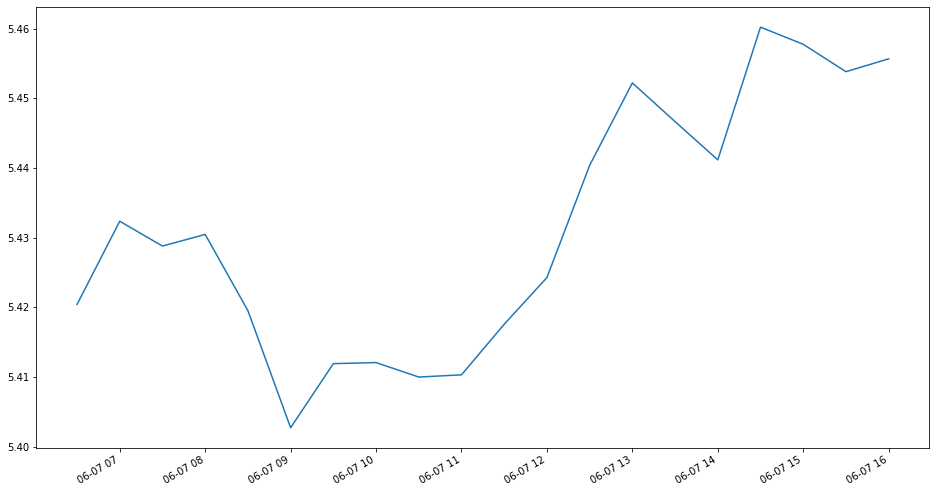

In [6]:
# hedge price function
def priceChart():
    leg1Chart= dataframe(leg1,timeframe, emalen)
    leg2Chart = dataframe(leg2,timeframe, emalen)

    leg1ChartClose = leg1Chart['c'].astype('float')
    leg2ChartClose = leg2Chart['c'].astype('float')

    hedgeChart = leg1ChartClose / leg2ChartClose
    return hedgeChart

# prints price chart
priceChart().plot(figsize=(16,9))

In [7]:
# current zscore
def currZscore():
    currStd = priceChart().std()
    currMean = priceChart().mean()
    a = priceChart().tolist()
    x = a[-1:]
    
    y = [float(i) for i in x]

    zscore = (y[0] - currMean)/currStd
    return round(zscore,5)

print("Current Z-Score = %s" % currZscore())

Current Z-Score = 1.31662


In [8]:
# short buy and long exit
def shortSide(leg1, leg2, legval):
    
    print("Short side function: ...")
    # amount for each leg
    priceLeg1 = dataframe(leg1,timeframe,emalen)['c'].astype('float')[-1].tolist()
    amountLeg1 = round(legval/priceLeg1,3)
    print ("Amount of leg1: {}". format(amountLeg1))
    
    priceLeg2 = dataframe(leg2,timeframe,emalen)['c'].astype('float')[-1].tolist()
    amountLeg2 = round(legval/priceLeg2,1)
    print ("Amount of leg2: {}". format(amountLeg2))
    print("-----")


    # short leg1    
    order1 = exchange.createOrder(newLeg1, 'market', 'sell', amountLeg1)
    print("Shorted leg 1")
    print(order1)
    # long leg 2
    order2 = exchange.createOrder(newLeg2, 'market', 'buy', amountLeg2)
    print("Longed leg 2")
    print(order2)
    
    inPos = True
    print ("inPos status before exit checks: {}". format(inPos))
    print("-----")

    
    # exit conds
    while (inPos == True):
        exZscore = currZscore()
            
        if exZscore <= 0:
            print ("Exiting! Current ZScore: {}". format(exZscore))
            order3 = exchange.createOrder (newLeg1, 'market', 'buy', amountLeg1)
            print("Long/ exited leg 1")
            print(order3)
            order4 = exchange.createOrder (newLeg2, 'market', 'sell', amountLeg2)
            print("Short/ exited leg 2")
            print(order4)
            print("-----")
            inPos = False
            print ("inPos status after exiting: {}". format(inPos))
        else:
            print ("Current ZScore: {}". format(exZscore))
            print("Sleeping 5 secs...")
            print("-----")
            time.sleep(5)
    
    "Calling entryConds for new buy session..."
    entryConds()

In [9]:
# long buy
def longSide(leg1, leg2, legval):
    
    print("Long side function: ...")
    # amount for each leg
    priceLeg1 = dataframe(leg1,timeframe,emalen)['c'].astype('float')[-1].tolist()
    amountLeg1 = round(legval/priceLeg1,3)
    print ("Amount of leg1: {}". format(amountLeg1))
    
    priceLeg2 = dataframe(leg2,timeframe,emalen)['c'].astype('float')[-1].tolist()
    amountLeg2 = round(legval/priceLeg2,1)
    print ("Amount of leg2: {}". format(amountLeg2))
    print("-----")
        
    # long leg1
    order1 = exchange.createOrder(newLeg1, 'market', 'buy', amountLeg1)
    print("Longed leg 1")
    print(order1)
    # short leg 2
    order2 = exchange.createOrder(newLeg2, 'market', 'sell', amountLeg2)
    print("Shorted leg 2")
    print(order2)
    print("-----")
    
    inPos = True
    print ("inPos status: {}". format(inPos))
    
    while (inPos == True):
        exZscore = currZscore()
            
        if exZscore >= 0:
            print ("Exiting! Current ZScore: {}". format(exZscore))
            order3 = exchange.createOrder (newLeg1, 'market', 'sell', amountLeg1)
            print("Short/ exited leg 1")
            print(order3)
            order4 = exchange.createOrder (newLeg2, 'market', 'buy', amountLeg2)
            print("Long/ exited leg 2")
            print(order4)
            print("-----")
            inPos = False
            print ("inPos status after exiting: {}". format(inPos))
        else:
            print ("Current ZScore: {}". format(exZscore))
            print("Sleeping 5 secs...")
            print("-----")
            time.sleep(5)
    
    "Calling entryConds"
    entryConds()

In [ ]:
# entry conds
def entryConds():
    entered = False
    print ("Entry status at start of loop: {}". format(entered))
    print("-----")
    
    while entered == False:
        enZscore = currZscore()
        print ("Entry Zscore: {}". format(enZscore))

        if enZscore >= 2:
            print("Entering short side")
            print("-----")
            entered = True
            shortSide(leg1,leg2,legval)
        elif enZscore <= -2:
            print("Entering long side")
            print("-----")
            entered = True
            longSide(leg1,leg2,legval)
        else:
            print("No entry. Sleeping 5 secs...")
            print("-----")
            time.sleep(5)

entryConds()

Entry status at start of loop: False
-----
Entry Zscore: 1.31662
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.31662
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.32661
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.32661
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.32661
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.39813
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.41476
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.28742
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.27734
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.28742
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.29749
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.30204
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.30204
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.24165
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.21639
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.27184
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.26172
No entry. Sleeping 5 se

Entry Zscore: 1.41992
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.52971
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.5172
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.51817
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.52438
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.50847
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.62874
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.62874
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.59483
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.56113
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.50033
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.60786
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.71624
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.69937
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.68283
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.64557
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.64557
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.59936
No entry. 

Entry Zscore: 1.16687
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.16687
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.13836
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.07761
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.1322
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.09233
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.09725
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.17311
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.89272
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.07703
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.98855
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.02112
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.01496
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.09285
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.09811
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.15051
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.09811
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.09811
No entry. 

Entry Zscore: 0.95395
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.98193
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.98193
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.98193
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.06653
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.08834
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.09444
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.09444
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.08515
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.09444
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.0787
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.12899
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.99942
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.14992
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.04947
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.03756
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.07861
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.09602
No entry. 

Entry Zscore: 0.93181
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.93181
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.90312
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.8484
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.96468
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.97417
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.95519
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.92537
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.94999
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.03502
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.88918
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.03074
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.86517
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.97783
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.02218
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.03157
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.02218
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.12374
No entry. 

Entry Zscore: 0.97036
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.06986
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.04858
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.01721
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.02032
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.00206
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.97036
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.97036
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.05592
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.04685
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.00128
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.03777
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.09204
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.05592
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.09749
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.06423
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.9419
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.9419
No entry. S

Entry Zscore: 0.7455
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.84873
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.84873
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.79815
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.78782
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.94124
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.78262
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.8308
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.76884
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.78748
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.71246
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.82991
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.76884
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.80194
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.6838
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.69771
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.74649
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.74727
No entry. Sl

Entry Zscore: 0.63592
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70134
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.715
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.78589
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.68335
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.78589
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.68335
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.73909
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.68335
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.73478
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70652
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.68409
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.8613
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.79686
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.73508
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.68427
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.71259
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70833
No entry. Sl

Entry Zscore: 0.79899
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.71871
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.66792
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.6869
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.63384
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.63508
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.63508
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.71528
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.69637
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.74943
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70066
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.73659
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.73243
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.67662
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.68083
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.60459
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.69978
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.66554
No entry. 

Entry Zscore: 0.75523
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.72814
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.79294
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.76014
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.75983
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.75042
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.77088
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.76922
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.71783
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.824
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.67905
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.64707
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.62187
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.65051
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.55892
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.47502
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.55066
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.66677
No entry. S

Entry Zscore: 0.73287
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.62271
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.56671
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.65894
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.66994
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.64409
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.64409
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.75482
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.7896
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.79504
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.74013
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.77036
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.78041
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.62635
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70977
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.78517
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.77419
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.7421
No entry. S

Entry Zscore: 1.00524
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.00332
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.04241
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.98683
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.94993
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.96942
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.87668
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.94016
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.94016
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.96942
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.95519
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.88282
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.94016
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.06589
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.15345
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.09959
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.13744
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.13744
No entry.

Entry Zscore: 0.78283
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.69282
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.79798
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70015
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.76031
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.62137
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.84689
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.7918
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.75552
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.69837
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.75073
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.76595
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.76595
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.76131
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.60535
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.63436
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70887
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.70887
No entry. 

Entry Zscore: 0.45341
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.45341
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.51796
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.51796
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.55983
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.45341
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.52681
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.52283
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.50136
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.50136
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.50136
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.57148
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.36294
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.41791
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.56499
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.49449
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.51012
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.46705
No entry.